In [682]:
%reload_ext autoreload
%autoreload 2

import os
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import pandas as pd
from astropy.io.ascii import read
from astropy.constants import sigma_sb
from astropy import units as u

import plot_utils as pu
import utils as ut

R_sun = 6.957e8 * u.m
L_sun = 3.828e26 * u.W
M_sun = 1.989e30 * u.kg

In [704]:
fold = '../data/geneva_models/'
files = os.listdir(fold)
paths = [os.path.join(fold, basename) for basename in files]
filenames = [file.split('.')[0] for file in files]
table_dic = {filenames[i].split('.')[0]: read(paths[i], data_start=2) for i in range(len(paths))}
print(table_dic[filenames[0]].columns)

# We want to sort by mass
mass_0 = [np.round(tab['mass'][0],2) for tab in table_dic.values()]
mass_filename_pairs = [(filename.split('.')[0], np.round(tab['mass'][0], 2)) for filename, tab in table_dic.items()]
sorted_mass_filename_pairs = sorted(mass_filename_pairs, key=lambda x: x[1])
table_dic = {filename: table_dic[filename] for filename, _ in sorted_mass_filename_pairs}

# And we want the density in SI units
for tabname, tab in table_dic.items():
    rhoc_cgs = 10**tab['lg(rhoc)']
    rhoc_SI = rhoc_cgs * (1e-3) * (1e-2)**(-3)
    tab['lg(rhoc)'] = np.log10(rhoc_SI)


# Now we define a dictionary where we store a few results
dic_results = {tabname: {} for tabname in table_dic}

print('Ages of H-exhaustion at core:')
for tabname in table_dic:



    mass = table_dic[tabname]['mass']
    lum =  table_dic[tabname]['lg(L)']
    dic_results[tabname]['mass_i'] = mass[0]
    dic_results[tabname]['mass_f'] = mass[-1]  
    dic_results[tabname]['lgL_i'] = lum[0] 

    m_i = mass[0]
    h_ab = table_dic[tabname]['1H_cen']
    time = table_dic[tabname]['time']
    # find indices where they reach a value less than 0.01
    h_ind = np.where(h_ab < 0.001)[0]
    t_h = time[h_ind[0]]
    dic_results[tabname]['hc_exh_ind'] = h_ind[0]
    dic_results[tabname]['t_hc_exh'] = t_h
    print(f'M={m_i:0.2f}: t={(t_h - time[0])*1e-6:.2f} Myr')

    tab = table_dic[tabname]
    L = 10**(np.array(tab['lg(L)']) + np.log10(L_sun.value))  
    T_eff = 10**(tab['lg(Teff)'])
    radius = np.sqrt(L/(4*np.pi * sigma_sb.value * T_eff**4)) / R_sun
    tab['radius'] = radius

<TableColumns names=('line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_1','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot')>
Ages of H-exhaustion at core:
M=0.80: t=21477.93 Myr
M=1.00: t=8480.49 Myr
M=1.25: t=4205.54 Myr
M=1.50: t=2223.20 Myr
M=2.00: t=1007.89 Myr
M=3.00: t=320.35 Myr
M=4.00: t=152.01 Myr
M=5.00: t=88.16 Myr
M=7.00: t=41.71 Myr
M=9.00: t=26.26 Myr
M=15.00: t=11.02 Myr
M=25.00: t=6.30 Myr
M=39.98: t=4.44 Myr


5.0
8.999972


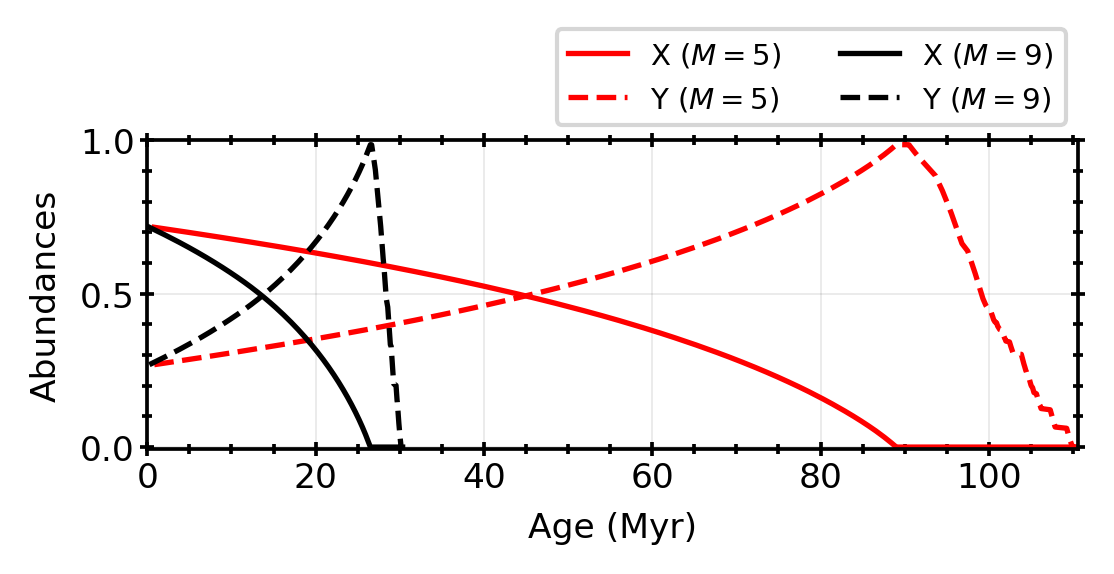

In [705]:
fig_size, rat = 540, 2
subplots = (1,1)
ts = 3.25
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        ts=ts, sw=0.35)
ax = axs[0][0]

k = 0
colors = ['red', 'black']
lw = 0.5

t_maxs = []
for filename in filenames:
    tab = table_dic[filename]
    mass = tab['mass']
    mass_in = np.round(mass[0],1)
    if mass_in in [5.0, 9.0]:
        print(mass[0])
        time = tab['time']*1e-6
        t_maxs.append(np.max(time))
        h_ab = tab['1H_cen']
        he_ab = tab['4He_cen'] 

        ax.plot(time, h_ab, 
                lw=lw*fs, c=colors[k],
                label = f'X $(M = {mass_in:0.0f})$'
                )
        ax.plot(time, he_ab, 
                lw=lw*fs, ls='--', c=colors[k],
                label = f'Y $(M = {mass_in:0.0f})$'
                )

        k+=1

ax.set_xlim(0, np.max(t_maxs))
ax.set_ylim(-0.005, 1)
ax.set_xlabel(r'Age (Myr)', fontsize=fs*ts)
ax.set_ylabel(r'Abundances', fontsize=fs*ts)
ax.legend(loc=(0.44, 1.05), fontsize=0.85*ts*fs, ncols=2) 
#ax.invert_xaxis()


savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'abundances.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')

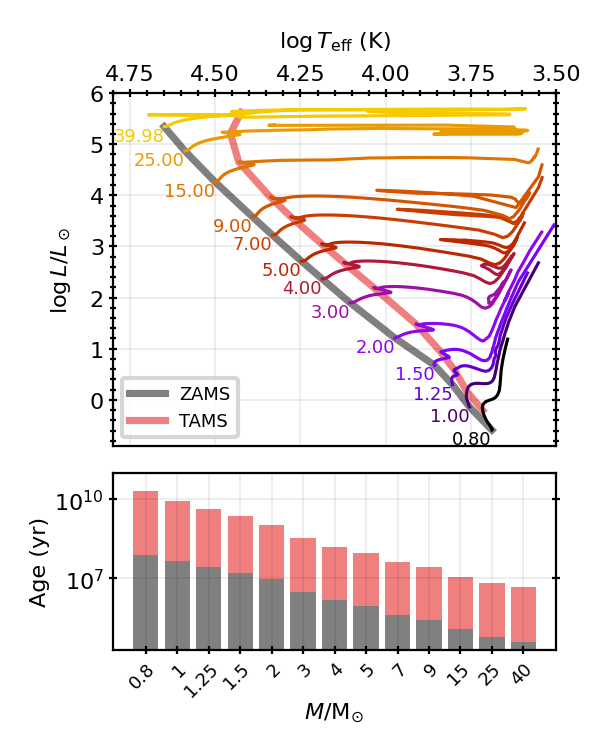

In [706]:
fig_size, rat = 720, 0.8
subplots = (2,1)
ts = 2.5
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        ts=ts, sw=0.25, hr=[2,1])
ax = axs[0][0]
ax1 = axs[1][0]

cmap = mpl.colormaps['gnuplot']
M = len(paths)
colors = [cmap(i/M) for i in range(M)]

for i, tab_name in enumerate(table_dic):
    tab = table_dic[tab_name]
    lgTeff = tab['lg(Teff)']
    lgL = tab['lg(L)']
    time = tab['time']
    m_i = tab['mass'][0]

    ax.plot(lgTeff, lgL,
            lw=0.35*fs, c=colors[i]
            )
    
    x0, y0 = lgTeff[0], lgL[0]

    ax.text(x0, y0, f'{m_i:0.2f}', fontsize=2*fs, color=colors[i], ha='right', va='top') 
        
teff_zams = [tab['lg(Teff)'][0] for tab in table_dic.values()]
l_zams = [tab['lg(L)'][0] for tab in table_dic.values()]

teff_tams = [tab['lg(Teff)'][dic_results[tabname]['hc_exh_ind']] for tabname, tab in table_dic.items()]
l_tams = [tab['lg(L)'][dic_results[tabname]['hc_exh_ind']] for tabname, tab in table_dic.items()]

ax.plot(teff_zams, l_zams, lw=0.8*fs, c='grey', ls='-', label='ZAMS', zorder=0)
ax.plot(teff_tams, l_tams, lw=0.8*fs, c='lightcoral', ls='-', label='TAMS', zorder=0)

ax.set_xlabel(r'$\log T_{\rm eff}$ (K)', fontsize=ts*fs)
ax.set_ylabel(r'$\log L/L_\odot$', fontsize=ts*fs)


ax.invert_xaxis()
ax.set_xlim(4.8, 3.5)

ax.legend(loc='lower left', fontsize=2*fs)

# set xaxis top
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")



t_exh = np.array([dic_results[tabname]['t_hc_exh'] for tabname in table_dic])
t_zams = np.array([table_dic[tabname]['time'][0] for tabname in table_dic])
m_is = np.array([dic_results[tabname]['mass_i'] for tabname in table_dic])

M = len(m_is)



# barplot of h_exh
ax1.bar(np.arange(M), np.array(t_exh), color='lightcoral', label='H')
# for i, t in enumerate(t_exh):
#     ax1.text(i, t, f'{t_exh[i]*1e-6:0.1f}', fontsize=2*fs, ha='center', va='bottom', color='firebrick')


ax1.bar(np.arange(M), np.array(t_zams), color='grey', label='H')
# for i, t in enumerate(t_zams):
#     ax1.text(i, t, f'{t_zams[i]*1e-6:0.2f}', fontsize=2*fs, ha='right', va='center', color='dimgray', zorder=2)

ax1.set_xticks(np.arange(M))
masses = ['0.8', '1', '1.25', '1.5', '2', '3', '4', '5', '7', '9', '15', '25', '40']
ax1.set_xticklabels([f'{m_is[i]:0.2f}' for i in range(M)], rotation=0)
ax1.set_xticklabels(masses, rotation=45, fontsize=2*fs, ha='right', va='top', rotation_mode='anchor')

ax1.set_yscale('log')

# # set yaxis on the right
ax1.xaxis.tick_bottom()
# ax1.yaxis.set_label_position("right")


ax1.set_ylabel(r'Age (yr)', fontsize=ts*fs, labelpad=0.5*fs)
ax1.set_xlabel(r'$M/{\rm M}_{\! \odot}$', fontsize=ts*fs, labelpad=0.15*fs)

ax1.tick_params(axis='x', which='minor', size=0)

ax1.set_ylim(None, 1e11)


savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'HR_plot.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')

In [715]:
print(f'{"Mass":<5} & {"ZAMS":<5} & {"TAMS":<5}')
for i, m in enumerate(m_is):
    print(f'{m:0.2f} & {t_zams[i]:0.2e} & {t_exh[i]:0.2e}')

Mass  & ZAMS  & TAMS 
0.80 & 7.48e+07 & 2.16e+10
1.00 & 4.49e+07 & 8.53e+09
1.25 & 2.74e+07 & 4.23e+09
1.50 & 1.60e+07 & 2.24e+09
2.00 & 9.15e+06 & 1.02e+09
3.00 & 2.86e+06 & 3.23e+08
4.00 & 1.43e+06 & 1.53e+08
5.00 & 8.33e+05 & 8.90e+07
7.00 & 4.02e+05 & 4.21e+07
9.00 & 2.49e+05 & 2.65e+07
15.00 & 1.18e+05 & 1.11e+07
25.00 & 5.97e+04 & 6.36e+06
39.98 & 3.64e+04 & 4.47e+06


[0.8  1.   1.25 1.5 ]
[2.       3.       4.       5.       6.999998 8.999972]
[14.998921 24.99536  39.981525]


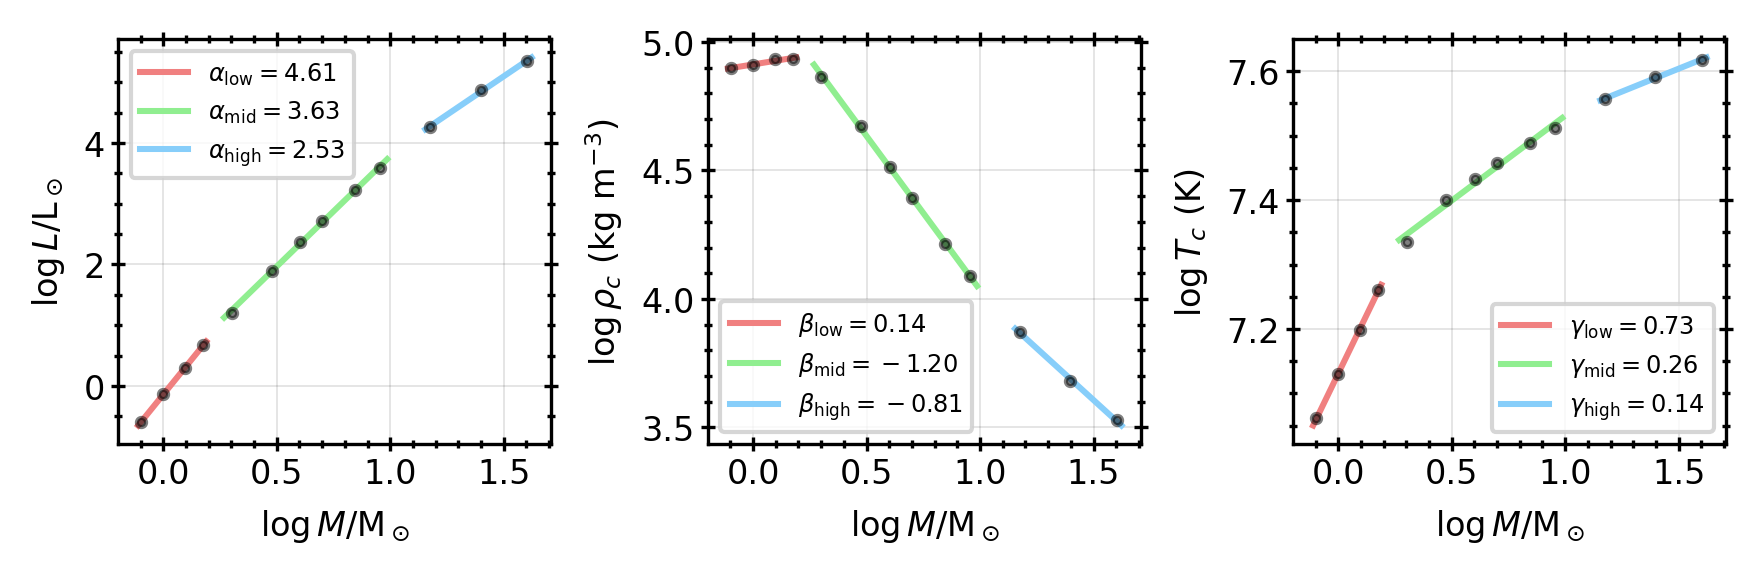

In [722]:
fig_size, rat = 540, 3.2
subplots = (1,3)
ts = 2.5
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        ts=ts, sw=0.25)
axs_f = [axs[0][0], axs[0][1], axs[0][2]]

mis = [np.log10(dic_results[tabname]['mass_i']) for tabname in table_dic]
lis = [dic_results[tabname]['lgL_i'] for tabname in table_dic]
lgrhocs = [table_dic[tabname]['lg(rhoc)'][0] for tabname in table_dic]
lgtcs = [table_dic[tabname]['lg(Tc)'][0] for tabname in table_dic]

masses = (10**np.array(mis))
masses_low = masses[masses < 8.0]
id_low_M = len(masses_low)

idxs = [(None, 4) , (4,-3), (-3, None)]
print(masses[idxs[0][0]:idxs[0][1]])
print(masses[idxs[1][0]:idxs[1][1]])
print(masses[idxs[2][0]:idxs[2][1]])

colors = ['lightcoral', 'lightgreen', 'lightskyblue']
labs = [r'{\rm low}', r'{\rm mid}', r'{\rm high}']
exps = [r'\alpha', r'\beta',  r'\gamma']

slopes = [[],[],[]]

ys = [lis, lgrhocs, lgtcs]
pos = ['upper left', 'lower left', 'lower right']
for i, ax in enumerate(axs_f):
    y = ys[i]

    for j, idx in enumerate(idxs):

        mis_ = np.array(mis)[idx[0]:idx[1]]
        y_ = np.array(y)[idx[0]:idx[1]]

        m_dif = np.max(mis_) - np.min(mis_)
        y_dif = np.max(y_) - np.min(y_)
        fact = 0.05

        m, b = np.polyfit(mis_, y_, 1)
        slopes[i].append(m)
        x = np.linspace(np.min(mis_) - fact*m_dif, np.max(mis_) + fact*m_dif, 100)
        y_fit = m*x + b
        ax.scatter(mis_, y_, s=1.5*fs, c='k', zorder=3, alpha=0.5)
        ax.plot(x, y_fit, lw=0.45*fs, c=colors[j], ls='-', label=f'${exps[i]}_{labs[j]}={m:0.2f}$', zorder=2)

        # ax.set_ylim(np.min(y_)-fact*y_dif, np.max(y_)+fact*y_dif)
        # ax.set_xlim(np.min(mis_)-fact*m_dif, np.max(mis_)+fact*m_dif)

    ax.set_xlabel(r'$\log M/{\rm M}_\odot$', fontsize=ts*fs)

    ax.legend(loc=pos[i], fontsize=1.8*fs)

axs[0][0].set_ylabel(r'$\log L/{\rm L}_\odot$', fontsize=ts*fs)
axs[0][1].set_ylabel(r'$\log \rho_c$ (kg m$^{-3}$)', fontsize=ts*fs)
axs[0][2].set_ylabel(r'$\log T_c$ (K)', fontsize=ts*fs)


savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'regressions.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')


In [717]:
# Homology relations

def L_M(n):
    f1 = 10*n + 31
    f2 = 5 + 2*n
    return f1/f2

def rho_M(n):
    f1 = 6 - 2*n
    f2 = 3+n
    return f1/f2

def Tc_M(n):
    f1 = 4
    f2 = n+3
    return f1/f2

def kappa(n):
    f1 = 4*n + 16
    f2 = 5 + 2*n
    return -f1/f2

print('Low Mass (<1.5). Kramers and p-p chain')
n = 4
print(f'L_M = {L_M(n):0.3f} | {slopes[0][0]:0.3f} | {(L_M(n) - slopes[0][0])/L_M(n):0.3e} ')
print(f'rho_M = {rho_M(n)+kappa(n)*(-3/(n+3)):0.3f} | {slopes[1][0]:0.3f} | {(rho_M(n)+kappa(n)*(-3/(n+3)) - slopes[1][0])/(rho_M(n)+kappa(n)*(-3/(n+3))):0.3e} ')
print(f'Tc_M = {Tc_M(n)+kappa(n)*(-1/(n+3)):0.3f} | {slopes[2][0]:0.3f} | {(Tc_M(n)+kappa(n)*(-1/(n+3)) - slopes[2][0])/(Tc_M(n)+kappa(n)*(-1/(n+3))):0.3e}')
print('\n')
print('Mid Mass (1.5<M<10). Kramers and CNO cycle')
n = 16
print(f'L_M = {L_M(n):0.3f} | {slopes[0][1]:0.3f} | {(L_M(n) - slopes[0][1])/L_M(n):0.3e}')
print(f'rho_M = {rho_M(n)+kappa(n)*(-3/(n+3)):0.3f} | {slopes[1][1]:0.3f} | {(rho_M(n)+kappa(n)*(-3/(n+3)) - slopes[1][1])/(rho_M(n)+kappa(n)*(-3/(n+3))):0.3e}')
print(f'Tc_M = {Tc_M(n)+kappa(n)*(-1/(n+3)):0.3f} | {slopes[2][1]:0.3f} | {(Tc_M(n)+kappa(n)*(-1/(n+3)) - slopes[2][1])/(Tc_M(n)+kappa(n)*(-1/(n+3))):0.3e}')
print('\n')
print('High Mass (M>10). Scattering and CNO cycle')
n = 16
print(f'L_M = {3} | {slopes[0][2]:0.3f} | {(3 - slopes[0][2])/3:0.3e}')
print(f'rho_M = {rho_M(n):0.3f} | {slopes[1][2]:0.3f} | {(rho_M(n) - slopes[1][2])/rho_M(n):0.3e}')
print(f'Tc_M = {Tc_M(n):0.3f} | {slopes[2][2]:0.3f} | {(Tc_M(n) - slopes[2][2])/Tc_M(n):0.3e}')


Low Mass (<1.5). Kramers and p-p chain
L_M = 5.462 | 4.610 | 1.559e-01 
rho_M = 0.769 | 0.144 | 8.127e-01 
Tc_M = 0.923 | 0.727 | 2.121e-01


Mid Mass (1.5<M<10). Kramers and CNO cycle
L_M = 5.162 | 3.631 | 2.966e-01
rho_M = -1.027 | -1.198 | -1.669e-01
Tc_M = 0.324 | 0.264 | 1.875e-01


High Mass (M>10). Scattering and CNO cycle
L_M = 3 | 2.531 | 1.562e-01
rho_M = -1.368 | -0.805 | 4.117e-01
Tc_M = 0.211 | 0.142 | 3.250e-01


In [681]:
# Homology relations

def L_M(n):
    f1 = 10*n + 31
    f2 = 5 + 2*n
    return f1/f2

def rho_M(n):
    f1 = 6 - 2*n
    f2 = 3+n
    return f1/f2

def Tc_M(n):
    f1 = 4
    f2 = n+3
    return f1/f2

def rho_M_kr(n):
    return rho_M(n)+kappa(n)*(-3/(n+3))

def Tc_M_kr(n):
    return Tc_M(n)+kappa(n)*(-1/(n+3))

print('Low Mass (<1.5). Kramers and p-p chain')
n = 4
print(f'L_M = {L_M(n):0.3f} | {slopes[0][0]:0.2f}')
print(f'rho_M = {rho_M_kr(n):0.3f} | {slopes[1][0]:0.2f}')
print(f'Tc_M = {Tc_M_kr(n):0.3f} | {slopes[2][0]:0.2f}')
print('\n')
print('Mid Mass (1.5<M<10). Kramers and CNO cycle')
n = 16
print(f'L_M = {L_M(n):0.3f} | {slopes[0][1]:0.2f}')
print(f'rho_M = {rho_M_kr(n):0.3f} | {slopes[1][1]:0.2f}')
print(f'Tc_M = {Tc_M_kr(n):0.3f} | {slopes[2][1]:0.2f}')
print('\n')
print('High Mass (M>10). Scattering and CNO cycle')
n = 16
print(f'L_M = {3} | {slopes[0][2]:0.2f}')
print(f'rho_M = {rho_M(n):0.3f} | {slopes[1][2]:0.2f}')
print(f'Tc_M = {Tc_M(n):0.3f} | {slopes[2][2]:0.2f}')


Low Mass (<1.5). Kramers and p-p chain
L_M = 5.462 | 4.61
rho_M = 0.769 | 0.14
Tc_M = 0.923 | 0.73


Mid Mass (1.5<M<10). Kramers and CNO cycle
L_M = 5.162 | 3.63
rho_M = -1.027 | -1.20
Tc_M = 0.324 | 0.26


High Mass (M>10). Scattering and CNO cycle
L_M = 3 | 2.53
rho_M = -1.368 | -0.81
Tc_M = 0.211 | 0.14


In [601]:
Ms[None:None]

array([ 0.8     ,  1.      ,  1.25    ,  1.5     ,  2.      ,  3.      ,
        4.      ,  5.      ,  6.999998,  8.999972, 14.998921, 24.99536 ,
       39.981525])

In [6]:
from astropy import units as u
from astropy.constants import k_B, h, c
import numpy as np
R = 8314
mu = (1/0.63 + 1/2)**(-1)
K0 = R/mu
K1 = 1e7 * 2**(-5/3)
ct1 = (K0/K1)
ct1_val = ct1
ct1_val = 3/2 * np.log10(ct1_val)
print(ct1_val)

-3.388332175526461


In [724]:
from astropy import units as u
from astropy.constants import k_B, h, c


lgTmin, lgTmax = 6.9, 9.5
lgTs = np.linspace(lgTmin, lgTmax, 100) * u.K

R = 8314  * u.s**(-2) * u.m**2 * u.K**(-1) 
mu = 0.63 

# P_ideal = P_e,deg
K0 = R/mu
K1 = 1e7 * 2**(-5/3) * u.m**4 * u.kg**(-2/3) * u.s**(-2) 
ct1 = (K0/K1)
ct1_val = ct1.value
ct1_val = 3/2 * np.log10(ct1_val)
lgrhoc_ideal_edeg = (3/2)*lgTs.value + ct1_val

# P_ideal = P_e,deg-r
K2 = 1.24e10 * 2**(-4/3) * u.m**3 * u.kg**(-1/3) * u.s**(-2) 
ct2 = (K0/K2)
ct2_val = ct2.value
ct2_val = 3 * np.log10(ct2_val)
lgrhoc_ideal_edegr = (3)*lgTs.value + ct2_val

# P_e,deg = P_e,deg-r
ct3 = K2/K1
ct3_val = ct3.value
ct3_val = 3*np.log10(ct3_val)
lgrhoc_edeg_edegr = np.full(lgTs.shape, ct3_val)

# P_ideal = P_rad
a = 8*np.pi**5 * k_B**4 / (15 * h**3 * c**3)
cte4 = a/(3*K0)
cte4_val = cte4.value
cte4_val = np.log10(cte4_val)
lgrhoc_rad = 3*lgTs.value + cte4_val



dif = np.abs(lgrhoc_ideal_edeg - lgrhoc_ideal_edegr)
idx = np.argmin(dif)


lgrhoc_ideal_edeg_edegr = np.concatenate((lgrhoc_ideal_edeg[:idx], lgrhoc_ideal_edegr[idx:]))

110
109
109
108


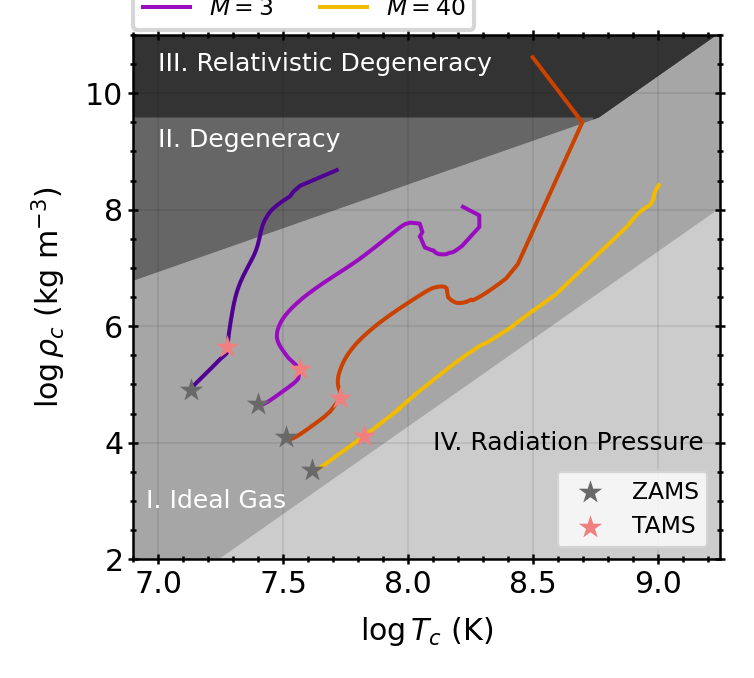

In [726]:
fig_size, rat = 720, 1
subplots = (1,1)
ts = 3
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        ts=ts, sw=0.25)
ax = axs[0][0]

k = 0
cmap = mpl.colormaps['gnuplot']
M = 4
colors = [cmap(i) for i in np.linspace(0.1, 0.9, M)]
lw = 0.4

Tc0s = []
rhoc0s = []
Tc_exh = []
rhoc_exh = []

for filename in filenames:
    tab = table_dic[filename]
    mass = tab['mass']
    mass_in = np.round(mass[0],1)
    if mass_in in [1, 3, 9, 40]:
        
        Tc = tab['lg(Tc)'][:]
        rhoc = tab['lg(rhoc)'][:]
        indx = dic_results[filename]['hc_exh_ind']
        print(indx)

        ax.plot(Tc, rhoc, 
                lw=lw*fs, c=colors[k],
                label = f'$M = {mass_in:0.0f}$'
                )
        
        Tc0s.append(Tc[0])
        rhoc0s.append(rhoc[0])
        Tc_exh.append(Tc[indx])
        rhoc_exh.append(rhoc[indx])
        
        k+=1


ax.scatter(Tc0s, rhoc0s, s=14.5*fs, c='dimgrey', zorder=3, marker='*', lw=0, label='ZAMS')
ax.scatter(Tc_exh, rhoc_exh, s=14.5*fs, c='lightcoral', zorder=3, marker='*', lw=0, label='TAMS')




cmap = mpl.colormaps['binary']

colors_fill = [cmap(i) for i in [0.2, 0.35, 0.6, 0.8]]

ax.fill_between(lgTs.value, 20, lgrhoc_ideal_edeg_edegr, 
                color=colors_fill[3], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[3])
ax.fill_between(lgTs[:idx].value, lgrhoc_edeg_edegr[:idx], lgrhoc_ideal_edeg_edegr[:idx], 
                color=colors_fill[2], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[2])
ax.fill_between(lgTs.value, lgrhoc_ideal_edeg_edegr, lgrhoc_rad, 
                color=colors_fill[1], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[1])
ax.fill_between(lgTs.value, lgrhoc_rad, 
                color=colors_fill[0], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[0])

# ax.plot(lgTs.value, lgrhoc_ideal_edeg_edegr, lw=0.5*fs, c='k', ls='--', zorder=0)
# ax.plot(lgTs[:idx].value, lgrhoc_edeg_edegr[:idx], lw=0.5*fs, c='k', ls='--', zorder=0)
# ax.plot(lgTs.value, lgrhoc_rad, lw=0.5*fs, c='k', ls='--', zorder=0)

ax.text(7, 10.5, 'III. Relativistic Degeneracy', fontsize=2.5*fs, color='w', ha='left', va='center')
ax.text(7, 9.2, 'II. Degeneracy', fontsize=2.5*fs, color='w', ha='left', va='center')
ax.text(6.95, 3, 'I. Ideal Gas', fontsize=2.5*fs, color='w', ha='left', va='center')
ax.text(8.1, 4, 'IV. Radiation Pressure', fontsize=2.5*fs, color='k', ha='left', va='center')

ax.set_ylim(2, 11)
ax.set_xlim(lgTmin, lgTmax)

ax.set_xlabel(r'$\log T_c$ (K)', fontsize=ts*fs)
ax.set_ylabel(r'$\log \rho_c$ (kg m$^{-3}$)', fontsize=ts*fs)

handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles[:k], labels[:k], loc=(0,1.01), fontsize=2.35*fs, ncols=2)
ax.add_artist(legend1)  # This keeps the first legend when adding the second


# Create legend for scatter plots
handles, labels = ax.get_legend_handles_labels()
legend2 = ax.legend(handles[k:], labels[k:], loc='lower right', fontsize=2.35*fs)

ax.set_xlim(6.9, 9.25)

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f't_rho_tracks.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')

## Exercise 4

In [627]:
star_m4 = table_dic['M004Z14V0']


time = star_m4['time'] * 1e-6
print(f'Total Age: {time[-1]:0.02f} Myr \n')

# Start of MS
id_MS = 0
t_MS = time[id_MS]

# End of MS | Start of Hook 
id_Hook = np.where(star_m4['1H_cen'] < 0.03)[0][0]
t_Hook = time[id_Hook]

# End of Hook | Start of Hertzprng Gap (HG)
id_HG = np.where(star_m4['1H_cen'] < 0.001)[0][0]
t_HG = time[id_HG]

# End of HG | Start of RGB
lum = star_m4['lg(L)'][id_HG:]
id_RGB = np.where(lum == np.min(lum))[0][0] + id_HG 
t_RGB = time[id_RGB]

# End of RGB | Start of Blue Loop
C_ab = star_m4['12C_cen'] + star_m4['13C_cen']
id_BL = np.where(C_ab > 0.001)[0][0]
BL_t = time[id_BL]

# End of BL | Start of AGB
He_ab = star_m4['4He_cen']
id_AGB = np.where(He_ab < 0.01)[0][0]
t_AGB = time[id_AGB]

idxs = [id_MS, id_Hook, id_HG, id_RGB, id_BL, id_AGB, -1]
print(idxs)
labels = ['MS', 'Hook', 'HG', 'RGB', 'BL', 'AGB', 'End']

_ = ''
titles = ['Phase', 'Star-End (Myr)', 'Duration (Myr)']
print(f'{titles[0]:<10} {titles[1]:<20} {titles[2]:<10}')
print('-'*40)
for i, idx in enumerate(idxs[:-1]):
    print(f'{labels[i]:<10} {time[idx]:0.2f}-{time[idxs[i+1]]:0.2f}{_:<10} {time[idxs[i+1]]-time[idx]:0.2f}')

Total Age: 195.53 Myr 

[0, 93, 109, 169, 187, 363, -1]
Phase      Star-End (Myr)       Duration (Myr)
----------------------------------------
MS         1.43-151.28           149.85
Hook       151.28-153.44           2.16
HG         153.44-156.22           2.78
RGB        156.22-156.94           0.72
BL         156.94-194.48           37.54
AGB        194.48-195.53           1.05


In [628]:
cmap = mpl.colormaps['jet']
M = 6
colors_ = [cmap(i) for i in np.linspace(0.05, 0.95, M)]

letters = ['A', 'B', 'C', 'D', 'E', 'F']

subplots = (2,2)
ratio = 3
hspace = 0
width_ratios = [0.4,1]
Fig = pu.Figure(theme='default', subplots=subplots, 
                ratio=ratio, hspace=hspace, wspace=0,
                width_ratios=width_ratios)
fig = Fig.fig
axes = Fig.axes
ts, fs = Fig.ts, Fig.fs

ax1 = axes[0][0]
ax2 = axes[1][0]
ax3 = axes[0][1]
ax4 = axes[1][1]

ax1.set_xticklabels([])
ax3.set_xticklabels([])

# Time where timeseries is split
t_h = 150

for ax in [ax1, ax2]:
    ax.spines['right'].set_visible(False)
    # remove right ticks
    ax.tick_params(axis='y', which='both', right=False)
    ax.set_xlim(0, t_h)
    #ticks = [25, 50, 75, 100, 125, 150]
    #ax.set_xticks(ticks)
    ax.set_ylim(0, 55)

for ax in [ax3, ax4]:
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    # remove left ticks
    ax.tick_params(axis='y', which='both', left=False)
    ax.set_xlim(t_h, time[-1])

# Stuff for abundance fill plot
elements = ut.read_element_groups('cen')
ab = {'H': None, 'He': None, 'C': None, 'O': None}
cmap = mpl.colormaps['binary']
M = 4
colors = [cmap(i) for i in np.linspace(0.1, 0.9, M)]
for el in ab:
    val = np.zeros(len(star_m4['time']))
    for group in elements[el]:
        val += star_m4[group]
    ab[el] = val


for ax in [ax1, ax2, ax3, ax4]:

    if ax in [ax1, ax3]:
        ax.fill_between(time, ab['H'], 0, color=colors[0], label='H', lw=0)
        ax.fill_between(time,
                        ab['H'] + ab['He'], 
                        ab['H'], lw=0*fs, color=colors[1], label='He')
        ax.fill_between(time,
                        ab['H'] + ab['He']+ab['C'], 
                        ab['H'] + ab['He'], lw=0, color=colors[2], label='C')
        ax.fill_between(time,
                        ab['H'] + ab['He']+ab['C'] + ab['O'], 
                        ab['H'] + ab['He'] + ab['C'], lw=0, color=colors[3], label='O')
        
        ax.set_ylim(0, 1)



    for i, idx in enumerate(idxs[:-1]):
        ax.plot([time[idx], time[idx]], [0, 100], lw=0.3*fs, c=colors_[i], ls='--', zorder=3)
        
        if ax in [ax2, ax4]:
            ax.set_ylim(0, 55)
            ax.plot(time[idx:idxs[i+1]], star_m4['radius'][idx:idxs[i+1]], lw=0.5*fs, c=colors_[i], label=labels[i])


        if i == 0:
            ax1.text(time[idx]+5, 0.9, f'{letters[i]}', fontsize=ts*fs, color='k', ha='left', va='center')
        elif (i != 0) and (i != 4) and (i != 5):
            ax3.text(time[idx]+0.2, 0.9, f'{letters[i]}', fontsize=ts*fs, color='k', ha='left', va='center')   
        elif i == 4:
            ax3.text(time[idx]+0.2, 0.75, f'{letters[i]}', fontsize=ts*fs, color='k', ha='left', va='center')
        else:
            ax3.text(time[idx]-0.4, 0.9, f'{letters[i]}', fontsize=ts*fs, color='w', ha='right', va='center')
  
ax2.set_ylabel(r'$R/{\rm R}_{\! \odot}$', fontsize=ts*fs)

ax1.set_ylabel(r'Abundances', fontsize=ts*fs)
ax1.legend(loc='lower left', fontsize=0.85*ts*fs, ncol=2)

ax2.legend(loc='upper left', fontsize=0.85*ts*fs, ncol=2)

fig.text(0.5, -0.015, r'Age (Myr)', fontsize=fs*ts, color='k', ha='center')    

relative_height = 0.755  
num_zigzags = 15
start_y = 0.12  
y = np.linspace(start_y, start_y + relative_height, 2 * num_zigzags)
start_x = 0.3415
width = 0.01  
x = np.array([start_x, start_x + width] * num_zigzags)

zigzag_line = Line2D(x, y, color='lightgray', lw=0.25*fs, zorder=1)
fig.add_artist(zigzag_line)



bbox1 = ax1.get_position()  # This gets the Bbox object which contains the axes position
x01, y01, width1, height1 = bbox1.x0, bbox1.y0, bbox1.width, bbox1.height

bbox3 = ax3.get_position()  # This gets the Bbox object which contains the axes position
x03, y03, width3, height3 = bbox3.x0, bbox3.y0, bbox3.width, bbox3.height

delta = 0.03
y = -0.1
height = 0.8

ax6 = fig.add_axes([x01, y-height, (bbox1.width + bbox3.width)*(0.5-delta), height]) 
ax6 = Fig.customize_axes(ax6)

ax5 = fig.add_axes([x01 + (bbox1.width + bbox3.width)*(0.5+delta), y-height, (bbox1.width + bbox3.width)*(0.5-delta), height]) 
ax5 = Fig.customize_axes(ax5, ylabel_pos='right')

ax5.fill_between(lgTs.value, 20, lgrhoc_ideal_edeg_edegr, 
                color=colors_fill[3], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[3])
ax5.fill_between(lgTs[:idx].value, lgrhoc_edeg_edegr[:idx], lgrhoc_ideal_edeg_edegr[:idx], 
                color=colors_fill[2], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[2])
ax5.fill_between(lgTs.value, lgrhoc_ideal_edeg_edegr, lgrhoc_rad, 
                color=colors_fill[1], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[1])
ax5.fill_between(lgTs.value, lgrhoc_rad, 
                color=colors_fill[0], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[0])

ax5.text(7, 10.5, 'III. Relativistic Degeneracy', fontsize=ts*fs, color='w', ha='left', va='center')
ax5.text(7.33, 8.5, r'e$^{-}$ Degeneracy', fontsize=ts*fs, color='w', ha='left', va='center')
ax5.text(8, 6, 'Ideal Gas', fontsize=ts*fs, color='w', ha='left', va='center')
ax5.text(8.1, 4.3, 'Radiation Pressure', fontsize=ts*fs, color='k', ha='left', va='center')


for i, idx in enumerate(idxs[:-1]):

    if i != 5:
        idx_f = idxs[i+1]+1
    else:
        idx_f = -1

    ax5.plot(star_m4['lg(Tc)'][idx:idx_f], star_m4['lg(rhoc)'][idx:idx_f], 
            lw=lw*fs, c=colors_[i]
            )
    ax6.plot(star_m4['lg(Teff)'][idx:idx_f], star_m4['lg(L)'][idx:idx_f], 
            lw=lw*fs, c=colors_[i]
            )

    if i == 0:
        ax5.text(star_m4['lg(Tc)'][idx]-0.03, star_m4['lg(rhoc)'][idx], f'{letters[i]}', fontsize=ts*fs, color='w', ha='right', va='center')
        ax6.text(star_m4['lg(Teff)'][idx], star_m4['lg(L)'][idx]-0.03, f'{letters[i]}', fontsize=ts*fs, color='k', ha='center', va='center')
    if i == 1:
        ax5.text(star_m4['lg(Tc)'][idx], star_m4['lg(rhoc)'][idx]+0.2, f'{letters[i]}', fontsize=ts*fs, color='w', ha='right', va='center')
        ax6.text(star_m4['lg(Teff)'][idx]-0.02, star_m4['lg(L)'][idx], f'{letters[i]}', fontsize=ts*fs, color='k', ha='center', va='center')
    if i == 2:
        ax5.text(star_m4['lg(Tc)'][idx]+0.04, star_m4['lg(rhoc)'][idx], f'{letters[i]}', fontsize=ts*fs, color='w', ha='center', va='center')
        ax6.text(star_m4['lg(Teff)'][idx], star_m4['lg(L)'][idx]+0.03, f'{letters[i]}', fontsize=ts*fs, color='k', ha='center', va='center')
    if i == 3:
        ax5.text(star_m4['lg(Tc)'][idx], star_m4['lg(rhoc)'][idx]+0.3, f'{letters[i]}', fontsize=ts*fs, color='w', ha='center', va='center')
        ax6.text(star_m4['lg(Teff)'][idx], star_m4['lg(L)'][idx]-0.03, f'{letters[i]}', fontsize=ts*fs, color='k', ha='center', va='center')
    if i == 4:
        ax5.text(star_m4['lg(Tc)'][idx], star_m4['lg(rhoc)'][idx]+0.3, f'{letters[i]}', fontsize=ts*fs, color='w', ha='center', va='center')
        ax6.text(star_m4['lg(Teff)'][idx]+0.015, star_m4['lg(L)'][idx], f'{letters[i]}', fontsize=ts*fs, color='k', ha='center', va='center')
    if i == 5:
        ax5.text(star_m4['lg(Tc)'][idx], star_m4['lg(rhoc)'][idx]-0.3, f'{letters[i]}', fontsize=ts*fs, color='w', ha='center', va='center')
        ax6.text(star_m4['lg(Teff)'][idx]+0.01, star_m4['lg(L)'][idx]-0.04, f'{letters[i]}', fontsize=ts*fs, color='k', ha='center', va='center')
    # elif (i != 0) and (i != 4) and (i != 5):
    #     ax3.text(time[idx]+0.2, 0.9, f'{letters[i]}', fontsize=ts*fs, color=colors_[i], ha='left', va='center')   
    # elif i == 4:
    #     ax3.text(time[idx]+0.2, 0.75, f'{letters[i]}', fontsize=ts*fs, color=colors_[i], ha='left', va='center')
    # else:
    #     ax3.text(time[idx]-0.4, 0.9, f'{letters[i]}', fontsize=ts*fs, color=colors_[i], ha='right', va='center')




ax5.set_ylim(4, 9)
ax5.set_xlim(7.3, 8.76)
#ax5.set_xlim(lgTmin, lgTmax)
ax5.set_xlabel(r'$\log T_c$ (K)', fontsize=ts*fs)
ax5.set_ylabel(r'$\log \rho_c$ (kg m$^{-3}$)', fontsize=ts*fs, labelpad=0.2*fs)
ax5.yaxis.set_label_position("right")

ax6.set_xlabel(r'$\log T_{\rm eff}$ (K)', fontsize=ts*fs)
ax6.set_ylabel(r'$\log L/L_\odot$', fontsize=ts*fs, labelpad=0.2*fs)
ax6.invert_xaxis()
ax6.set_xlim(4.21, 3.6)
ax6.set_ylim(2.2, 2.9)

Fig.save('../figures/ex4.png', bbox_inches='tight')

plt.close()

In [737]:
print(np.array(star_m4['radius'])[id_MS])
print(np.array(star_m4['radius'])[id_Hook])
print(np.array(star_m4['radius'])[id_HG])
print(np.array(star_m4['radius'])[id_RGB])
print(np.array(star_m4['radius'])[id_BL])
print(np.array(star_m4['radius'])[id_AGB])
print(np.array(star_m4['radius'])[-1])

2.1501272378016987
4.693114617218905
4.157824565744387
18.630120368458808
50.74399561550036
31.466443600233614
45.567862889855746


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


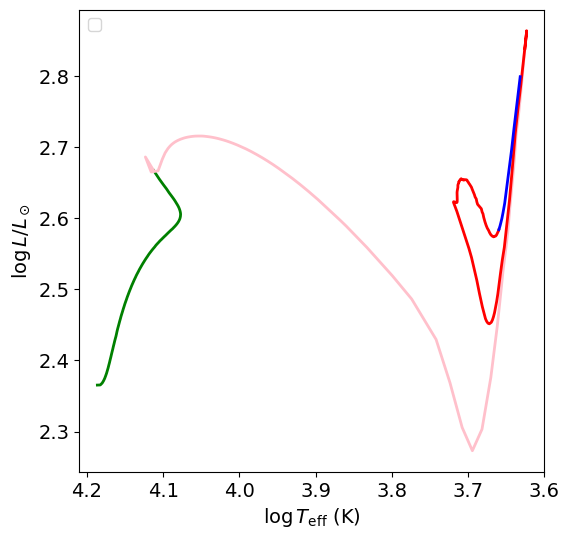

In [745]:
# Start of MS
id_MS = 0

# End of MS | Start of Hertzprng Gap and RGB (HG+RGB)
# se acaba el hidrogenooooo
id_RGB = np.where(star_m4['1H_cen'] < 0.001)[0][0]

# End of RGB | Start of Blue Loop
# Se empieza a quemar helioooooo
C_ab = star_m4['12C_cen'] + star_m4['13C_cen']
id_BL = np.where(C_ab > 0.001)[0][0]

# End of BL | Start of AGB
# se acaba el helioooo
id_AGB = np.where(star_m4['4He_cen'] < 0.01)[0][0]



# plot figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plotea entre cada indice
ax.plot(star_m4['lg(Teff)'][id_MS:id_RGB], star_m4['lg(L)'][id_MS:id_RGB], c='g', lw=2)
ax.plot(star_m4['lg(Teff)'][id_RGB-1:id_BL], star_m4['lg(L)'][id_RGB-1:id_BL], c='pink', lw=2)
ax.plot(star_m4['lg(Teff)'][id_BL-1:id_AGB], star_m4['lg(L)'][id_BL-1:id_AGB], c='r', lw=2)
ax.plot(star_m4['lg(Teff)'][id_AGB-1:-1], star_m4['lg(L)'][id_AGB-1:-1], c='b', lw=2)    

ax.invert_xaxis()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(r'$\log T_{\rm eff}$ (K)', fontsize=14)
ax.set_ylabel(r'$\log L/L_\odot$', fontsize=14)

ax.set_xlim(4.21, 3.6)

ax.legend(loc='best', fontsize=12)

(0.0, 1.0)

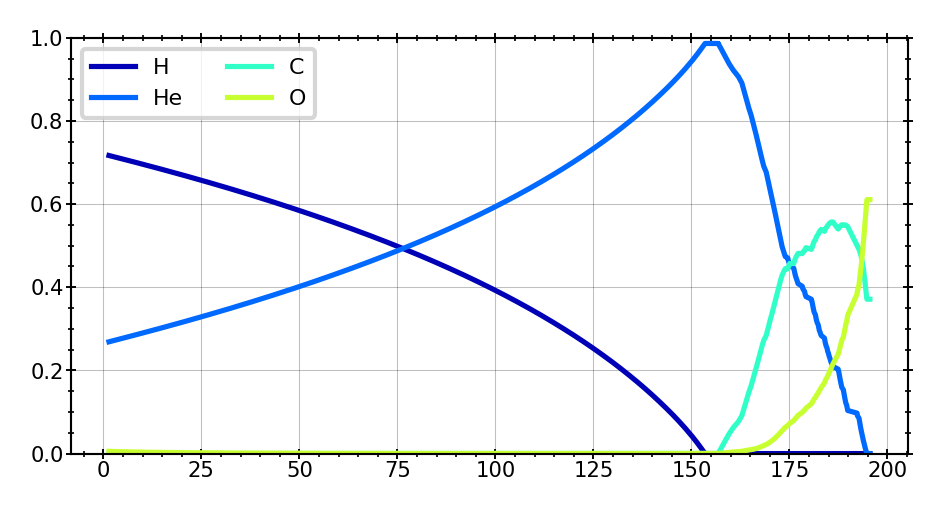

In [636]:
fig = pu.Figure(theme='default')
ax = fig.axes
ax = ax[0][0]


ax.plot(time, ab['H'], color=colors_[0], label='H', lw=lw*fs)
ax.plot(time,
                ab['He'], 
                 lw=lw*fs, color=colors_[1], label='He')
ax.plot(time,
                ab['C'], 
                lw=lw*fs, color=colors_[2], label='C')
ax.plot(time,
                ab['O'], 
               lw=lw*fs, color=colors_[3], label='O')

ax.legend(loc='upper left', fontsize=0.85*ts*fs, ncol=2)

ax.set_ylim(0, 1)

In [ ]:


for ax in [ax3, ax4]:
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    # remove left ticks
    ax.tick_params(axis='y', which='both', left=False)
    ax.set_xlim(t_h*1e-6, star_m4['time'][-1]*1e-6)

    ax.plot([t_MS*1e-6, t_MS*1e-6], [0, 100], lw=0.5*fs, c=colors_[0], ls='--', label='MS', zorder=3)
    ax.plot([t_Hook*1e-6, t_Hook*1e-6], [0, 100], lw=0.5*fs, c=colors_[1], ls='--', label='Hook', zorder=3)
    ax.plot([t_HG*1e-6, t_HG*1e-6], [0, 100], lw=0.5*fs, c=colors_[2], ls='--', label='Hook', zorder=3)    
    ax.plot([t_C*1e-6, t_C*1e-6], [0, 100], lw=0.5*fs, c=colors_[3], ls='--', label='C', zorder=3)
    ax.plot([t_He*1e-6, t_He*1e-6], [0, 100], lw=0.5*fs, c=colors_[-2], ls='--', label='He', zorder=3)

    ax.set_ylim(0, 55)

for ax in [ax2, ax4]:
    ax.plot(star_m4['time'][:MS_ind]*1e-6, star_m4['radius'][:MS_ind], lw=0.5*fs, c=colors_[0])
    ax.plot(star_m4['time'][MS_ind:Hook_ind]*1e-6, star_m4['radius'][MS_ind:Hook_ind], lw=0.5*fs, c=colors_[1])
    ax.plot(star_m4['time'][Hook_ind:He_ind]*1e-6, star_m4['radius'][Hook_ind:He_ind], lw=0.5*fs, c=colors_[2])
    ax.plot(star_m4['time'][He_ind:]*1e-6, star_m4['radius'][He_ind:], lw=0.5*fs, c=colors_[3])

ax2.set_ylabel(r'$R/{\rm R}_{\! \odot}$', fontsize=ts*fs)

elements = ut.read_element_groups('cen')
ab = {'H': None, 'He': None, 'C': None, 'O': None}
cmap = mpl.colormaps['binary']
M = 4
colors = [cmap(i) for i in np.linspace(0.1, 0.9, M)]

for el in ab:
    val = np.zeros(len(star_m4['time']))
    for group in elements[el]:
        val += star_m4[group]
    ab[el] = val

for ax in [ax1, ax3]:
    ax.fill_between(star_m4['time']*1e-6, ab['H'], 0, color=colors[0], label='H', lw=0)
    ax.fill_between(star_m4['time']*1e-6,
                    ab['H'] + ab['He'], 
                    ab['H'], lw=0*fs, color=colors[1], label='He')
    ax.fill_between(star_m4['time']*1e-6,
                    ab['H'] + ab['He']+ab['C'], 
                    ab['H'] + ab['He'], lw=0, color=colors[2], label='C')
    ax.fill_between(star_m4['time']*1e-6,
                    ab['H'] + ab['He']+ab['C'] + ab['O'], 
                    ab['H'] + ab['He'] + ab['C'], lw=0, color=colors[3], label='O')
    
    ax.set_ylim(0, 1)

ax1.set_ylabel(r'Abundances', fontsize=ts*fs)
ax1.legend(loc='lower left', fontsize=2*fs, ncol=2)

fig.text(0.5, -0.015, r'Age (Myr)', fontsize=fs*ts, color='k', ha='center')





relative_height = 0.755  
num_zigzags = 15
start_y = 0.12  
y = np.linspace(start_y, start_y + relative_height, 2 * num_zigzags)
start_x = 0.4523  
width = 0.01  
x = np.array([start_x, start_x + width] * num_zigzags)

zigzag_line = Line2D(x, y, color='lightgray', lw=0.25*fs, zorder=1)
fig.add_artist(zigzag_line)


bbox1 = ax1.get_position()  # This gets the Bbox object which contains the axes position
x01, y01, width1, height1 = bbox1.x0, bbox1.y0, bbox1.width, bbox1.height

bbox3 = ax3.get_position()  # This gets the Bbox object which contains the axes position
x03, y03, width3, height3 = bbox3.x0, bbox3.y0, bbox3.width, bbox3.height

delta = 0.03
y = -0.1
height = 0.8

ax6 = fig.add_axes([x01, y-height, (bbox1.width + bbox3.width)*(0.5-delta), height]) 
ax6 = Fig.customize_axes(ax6)

ax5 = fig.add_axes([x01 + (bbox1.width + bbox3.width)*(0.5+delta), y-height, (bbox1.width + bbox3.width)*(0.5-delta), height]) 
ax5 = Fig.customize_axes(ax5, ylabel_pos='right')

ax5.fill_between(lgTs.value, 20, lgrhoc_ideal_edeg_edegr, 
                color=colors_fill[3], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[3])
ax5.fill_between(lgTs[:idx].value, lgrhoc_edeg_edegr[:idx], lgrhoc_ideal_edeg_edegr[:idx], 
                color=colors_fill[2], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[2])
ax5.fill_between(lgTs.value, lgrhoc_ideal_edeg_edegr, lgrhoc_rad, 
                color=colors_fill[1], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[1])
ax5.fill_between(lgTs.value, lgrhoc_rad, 
                color=colors_fill[0], alpha=1, zorder=-1, lw=0.1*fs,
                edgecolor=colors_fill[0])


ax5.text(7, 10.5, 'III. Relativistic Degeneracy', fontsize=ts*fs, color='w', ha='left', va='center')
ax5.text(7, 9.2, 'II. Degeneracy', fontsize=ts*fs, color='w', ha='left', va='center')
ax5.text(6.95, 3, 'I. Ideal Gas', fontsize=ts*fs, color='w', ha='left', va='center')
ax5.text(8.1, 4, 'IV. Radiation Pressure', fontsize=ts*fs, color='k', ha='left', va='center')

ax5.set_ylim(2, 11)
ax5.set_xlim(lgTmin, lgTmax)

ax5.set_xlabel(r'$\log T_c$ (K)', fontsize=ts*fs)
ax5.set_ylabel(r'$\log \rho_c$ (kg m$^{-3}$)', fontsize=ts*fs, labelpad=0.2*fs)
# set label on the right
ax5.yaxis.set_label_position("right")

ax5.plot(star_m4['lg(Tc)'][:MS_ind], star_m4['lg(rhoc)'][:MS_ind], 
        lw=lw*fs, c=colors_[0],
        label = f'$M = {mass_in:0.0f}$'
        )


ax7 = fig.add_axes([0.18, -0.385, 0.26, 0.2]) 
ax7 = Fig.customize_axes(ax7, xlabel_pos='top')

ax7.invert_xaxis()
ax7.set_xlim(3.721, 3.62)
ax7.set_ylim(2.4, 2.9)

for ax in [ax6, ax7]:

    ax.plot(star_m4['lg(Teff)'][:MS_ind], star_m4['lg(L)'][:MS_ind], 
            lw=lw*fs, c=colors_[0],
            )
    ax.plot(star_m4['lg(Teff)'][MS_ind:Hook_ind], star_m4['lg(L)'][MS_ind:Hook_ind], 
            lw=lw*fs, c=colors_[1],
            )
    ax.plot(star_m4['lg(Teff)'][Hook_ind:HG_ind], star_m4['lg(L)'][Hook_ind:HG_ind], 
            lw=lw*fs, c=colors_[2],
            )
    ax.plot(star_m4['lg(Teff)'][HG_ind-1:C_ind], star_m4['lg(L)'][HG_ind-1:C_ind], 
            lw=lw*fs, c=colors_[3],
            )
    ax.plot(star_m4['lg(Teff)'][C_ind:He_ind], star_m4['lg(L)'][C_ind:He_ind], 
            lw=lw*fs, c=colors_[4],
            )
    ax.plot(star_m4['lg(Teff)'][He_ind:], star_m4['lg(L)'][He_ind:], 
            lw=lw*fs, c=colors_[5],
            )


ax6.set_xlabel(r'$\log T_{\rm eff}$ (K)', fontsize=ts*fs)
ax6.set_ylabel(r'$\log L/L_\odot$', fontsize=ts*fs, labelpad=0.2*fs)

ax6.invert_xaxis()
ax6.set_xlim(4.2, 3.6)
ax6.set_ylim(2.25, 3.3)

#ax6.legend(loc='lower left', fontsize=ts*fs)




# ax7.plot(star_m4['lg(Teff)'][:MS_ind], star_m4['lg(L)'][:MS_ind], 
#         lw=lw*fs, c=colors_[0],
#         )




Fig.save('../figures/ex4.png', bbox_inches='tight')